# Ridge regression

This is a regression technique wich allows to deal with the multicollinearity of the features and try to reduce the overfitting of the data. 
The mechanisc is to minimize two elements, the RSS and the objective function tuned by a certain parameter $\alpha $ , so the objective function is: 

$$ \lVert y - Xw \rVert ^2_2 + \alpha \lVert w \rVert^2_2 $$

The tunning parameter alpha controls the model complexity and the a trade off between variance and bias.

1. the inhability for the model to capture the true relationship is called bias. How well the model fits our data 
2. how well model does on a completely new dataset variance 

use the hyper parameter called alpha , to add a bias , prevent the model from real, it will have better accurancy on the testing set, it means it will not overfit in the training set.  

## Dataset

The dataset used in this regression has 10 features and 20639 observations. In more detailes the columns are:

1.	longitude: A measure of how far west a house is
2.	latitude: A measure of how far north a house is
3.	housingMedianAge: Median age of a house within a block
4.	totalRooms: Total number of rooms within a block
5.	totalBedrooms: Total number of bedrooms within a block
6.	population: Total number of people residing within a block
7.	households: Total number of households, a group of people residing within a home unit, for a block
8.	medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9.	medianHouseValue: Median house value for households within a block (measured in US Dollars)
10.	 oceanProximity: Location of the house w.r.t ocean/sea

the dataset is avaible from this website : --------


## Libraries 

For this analysis, we will use a few libraries for managing and transform the database as well as to implement the ridge regression, perform the model selection and validation. First, let's download the libraries 

In [62]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import decomposition

## Dataset overview

We open the database to check the structure and show the head,and take a look of its descriptive statistics.



In [63]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

In [64]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [65]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [66]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.52,34.18,34.0,2307.0,388.0,1168.0,427.0,4.2143,245400.0,<1H OCEAN
1,-118.27,33.99,41.0,656.0,162.0,730.0,170.0,1.8047,101800.0,<1H OCEAN
2,-117.25,33.36,6.0,3725.0,960.0,2833.0,915.0,2.3214,247000.0,<1H OCEAN
3,-117.22,32.81,21.0,1703.0,335.0,902.0,369.0,3.7813,362500.0,NEAR OCEAN
4,-121.42,38.62,41.0,1087.0,272.0,462.0,219.0,2.0224,64900.0,INLAND


Here is the distribution of the values of the target variable `median_house_value`. 
It looks like a normal distribution with a group of outliers on the highest value of the house. 

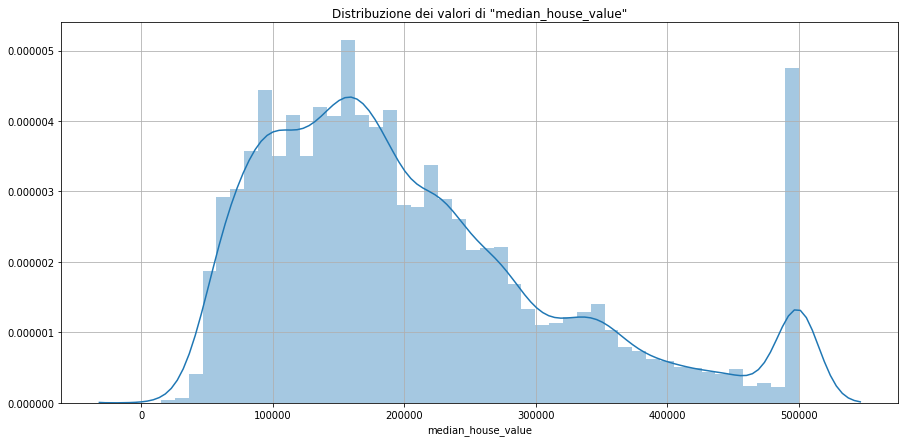

In [67]:
plt.figure(figsize=(15, 7))
plt.title('Distribuzione dei valori di "median_house_value"')

seaborn.distplot(data_frame[column_to_predict])

plt.grid()
plt.show()

-----------------------------------
## Data pre-processing 
Before performing the analysis we create the constants and and define the statistical elements of the analysis.

The target value is the `median_house_value` which is predicted based on the features of different houses.

Shuffle the data to reduce the error and to give a normal distribution to the whole dataset. 


In [68]:
shuffleDataSet = True

column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

#### MSE
The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.
#### R²
The coefficient R² is defined as $ 1 - {u \over v} $, where u is the residual sum of squares $ \sum (y - y')^2 $ and v is the total sum of squares $ \sum (y - \bar{y})^2 $.

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.
### $\alpha $ 
Selection of values of the tuning parameter $\alpha $ 

In [69]:
RMS = 'neg_mean_squared_error'
R2 = 'r2'

#scoring = R2
#scoring_neg = 1
#scoring_label = 'R²'

scoring = RMS
scoring_neg = -1
scoring_label = 'MSE'

In [70]:
alphas = numpy.linspace(1e-5, 1, 20)
alphas

array([1.00000000e-05, 5.26410526e-02, 1.05272105e-01, 1.57903158e-01,
       2.10534211e-01, 2.63165263e-01, 3.15796316e-01, 3.68427368e-01,
       4.21058421e-01, 4.73689474e-01, 5.26320526e-01, 5.78951579e-01,
       6.31582632e-01, 6.84213684e-01, 7.36844737e-01, 7.89475789e-01,
       8.42106842e-01, 8.94737895e-01, 9.47368947e-01, 1.00000000e+00])

### Outliers , missing values and categorical features
The outliers in the target variable can be a trouble for the analysis so we drop them to obtain a smooth distribution. 

In [71]:
outliers = data_frame[data_frame[column_to_predict] == 500001].index

print(f'There are {len(outliers)} outliers')

data_frame.drop(outliers, inplace=True)

There are 965 outliers


Now the distribution is much better :) 

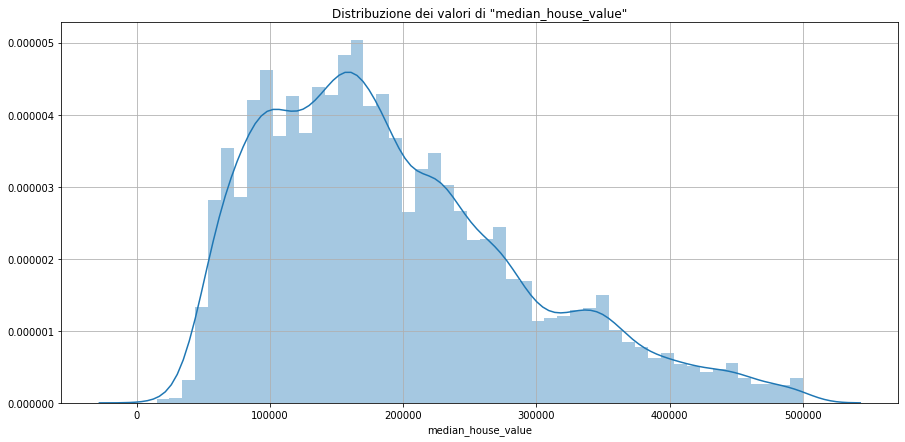

In [72]:
plt.figure(figsize=(15, 7))
plt.title('Distribuzione dei valori di "median_house_value"')

seaborn.distplot(data_frame[column_to_predict])

plt.grid()
plt.show()


The dataset contains missing values which are removed. This procedure is necessary to avoid errors in the execution.

In [73]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)



Categorical values cannot be treated as such for the statistical analysis, therefore they must be transormed in numbers.
-----We generate columns for each element of the categorical feature. -----------


We assign the categorical value to 4 different values 1-4

In [74]:
labelencoder = LabelEncoder()

for c in categories_columns:
    c_name = c + '_cat'
    data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
    numerics_columns.append(c_name)
    
data_frame.drop(columns=categories_columns, inplace=True)

### Correlation of the dataset
Explore the Peasrson's coefficient of correlation and build a simmetric correlation matrix between the features. This procedure is helpeful to eventually reduce the dimension of the dataset. 
Pearson's coefficient is determined by :


$$ r_{i,j} = \frac{\sum_{t=1}^m (x_{i,t}-\mu_i)(x_{j,t}-\mu_j)}{\sqrt{\sum_{t=1}^m (x_{i,t}-\mu_i)^2}\sqrt{\sum_{t=1}^m (x_{j,t}-\mu_j)^2}} $$

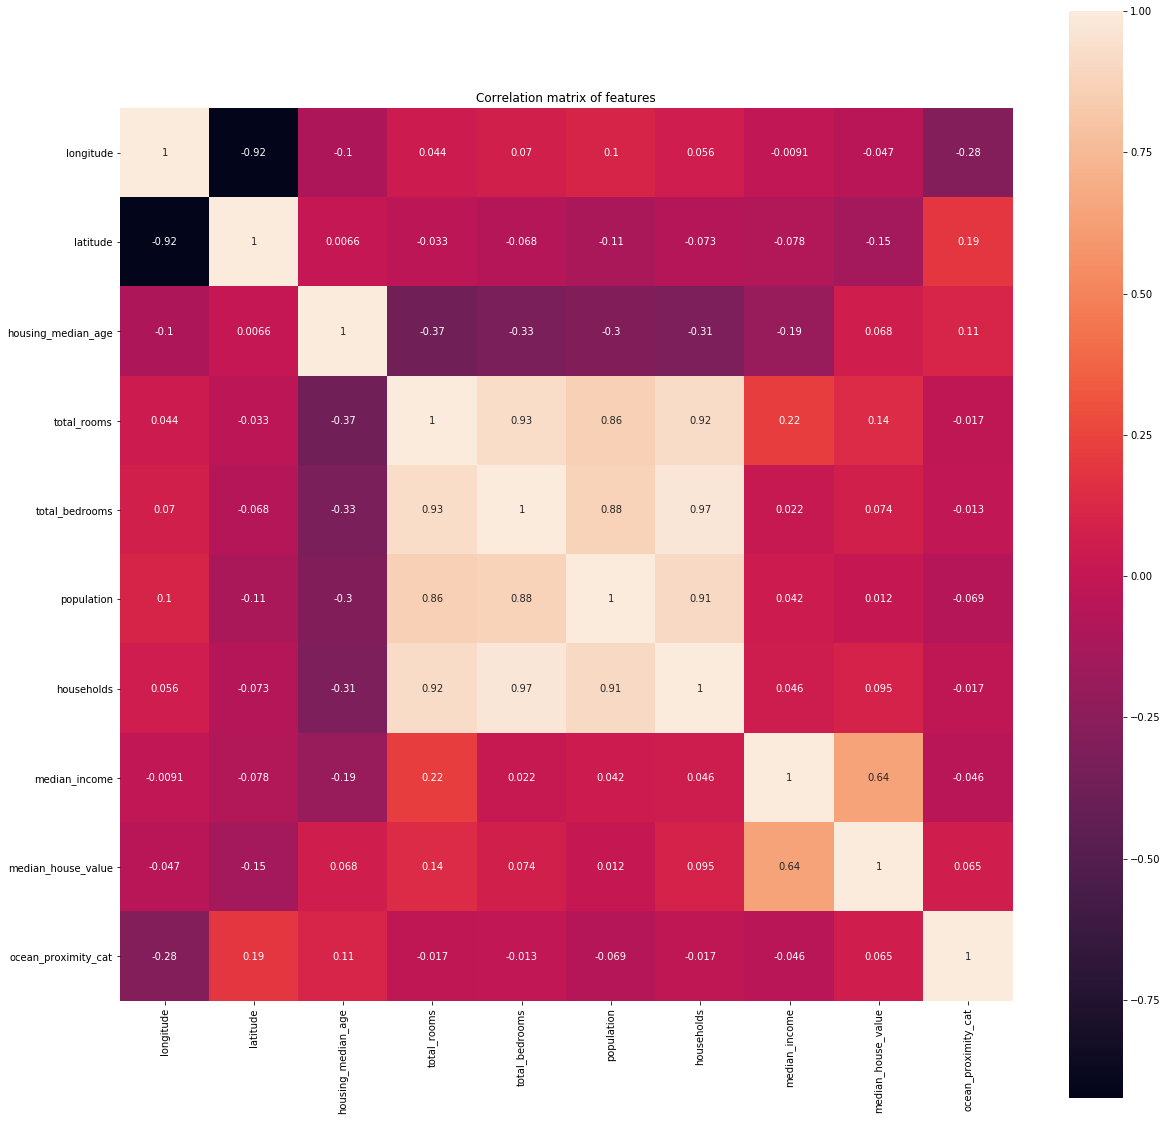

In [75]:
corr = data_frame.corr()
plt.figure(figsize=(20, 20))
plt.title('Correlation matrix of features')
seaborn.heatmap(corr, square=True, annot=True)
plt.show()

The coefficient is in between -1 and +1, when it is close to |1| then there is a correlation (positive or negative) otherwise if the coefficient is close to 0 there isn't any correlation. If some features are linearly correlated they are not useful, because we can explain one feature through the correlated one.

In [76]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_cat
longitude,NaN,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.930916,0.859590,0.921102,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.930916,NaN,0.875270,0.974006,NaN,NaN,NaN
population,NaN,NaN,NaN,0.859590,0.875270,NaN,0.908997,NaN,NaN,NaN
households,NaN,NaN,NaN,0.921102,0.974006,0.908997,NaN,NaN,NaN,NaN


As we can see the pairs of the most correlated features are 
   
   
    households - total_bedrooms
    population - household 
    total_rooms - total_bedrooms
    total_bedroom - households
    latitude - longitude 
Delete the correlated features

    latitude
    population
    total_rooms
     


In [77]:
#columns_to_remove = ['latitude', 'population', 'total_rooms']
columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

-----------------------------------------------------
## Scaler
Transform features by scaling each feature to a given range. This is done for faster convergence, and because we are implementing an algorithm that uses Eucleadian distance.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

This transformation is often used as an alternative to zero mean, unit variance scaling.

In [78]:
useMinMaxScaler = True

if useMinMaxScaler:
    column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
    cols = list(range(0, data_frame.shape[1]))
    cols.remove(column_to_predict_idx)

    scaler = MinMaxScaler()
    scaler.fit(data_frame)
    data_frame = scaler.transform(data_frame)

    X = data_frame[:, cols]
    y = data_frame[:, column_to_predict_idx]

# Learning algorithm
Before starting to learn the algorithm, the dataset must be splitted in  subsets in order to preserve some data for the validation of the method. 
### Cross-validated risk estimate
Cross Validation is is a method that allows to perform selection and  validation of the learning algorithm. 
set aside a portion of the data for the test set and perform multiple interations on the training data, splitted in k-folds and validate the hyperparameter to one fold per time . Then compare to the test data. 
Method for comparing is the root mean squared error. 
normalize to get values normalized 
Use the 5-fold cross validation usign the built in function `cross_val_score`     
              
             

In [93]:
# implementing ridge regression 
learner = Ridge(alpha=0.01, normalize=True)
scores = cross_val_score(learner, X, y, cv=5, scoring=RMS)
print(f'Cross-validated risk estimate: {-scores.mean()}')

Cross-validated risk estimate: 0.016415448018492523


### Learning curve
For tuning the hyper-parameters of an estimator, in our case alpha of the ridge regression, use the grid search. 
random split into training and test sets  

In [94]:
# records da 1 a 2851, step 550 = 7 punti
sizes = range(1, 3851, 550)

# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X, y, train_sizes=sizes, cv=5, scoring=RMS)

In [95]:
min_ts = int(X.shape[0] * 0.1)
max_ts = int(X.shape[0] * 0.8)
step_ts = int(X.shape[0] * 0.05)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

range(1967, 15740, 983)


### Standard deviation
Standard deviation is the most important tool for dispersion measurement in a distribution. Technically, the standard deviation is the square root of the arithmetic mean of the squares of deviations of observations from their mean value.
### Arithmetic Mean
Mean is the measure of central tendency most commonly used. Mean is equal to the sum of all the values of a collection of data divided by the number of values in the data.

In [82]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

In [101]:
val_score_mean.mean()

0.02133798536674919

In [102]:
train_score_mean.mean()

0.014312840879116709

In [103]:
train_score_std.mean()

0.0003602967581135932

In [104]:
val_score_std.mean()

0.001234045627185874

In [107]:
plt.figure(figsize=(0.0003

, 0.001))
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

ValueError: operands could not be broadcast together with shapes (15,) (7,) 

RuntimeError: libpng signaled error

<Figure size 0.0216x0.072 with 1 Axes>

## Principal Component Analysis
PCA is a method used to reduce number of variables in your data by extracting important one from a large pool. It reduces the dimension of your data with the aim of retaining as much information as possible. In other words, this method combines highly correlated variables together to form a smaller number of an artificial set of variables which is called “principal components” that account for most variance in the data.

In [84]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

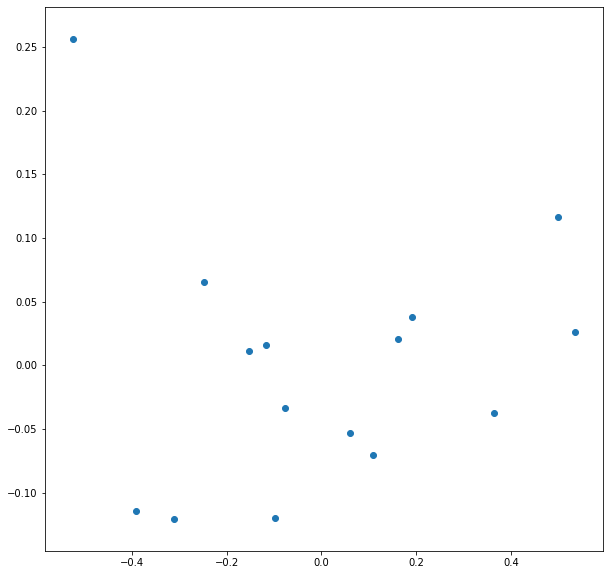

In [85]:
plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:, 0], coef_pca[:, 1])


In [86]:
pca = decomposition.PCA(n_components=X.shape[1])
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

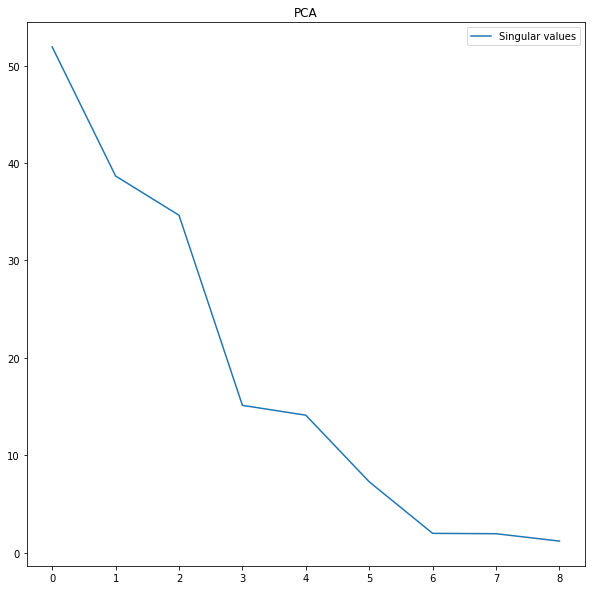

In [87]:
plt.figure(figsize=(10, 10))
plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

We project all the datapoints on the principal components. Then we check the learning curve again.

In [22]:
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)

In [23]:
X

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-121.23,37.84,28.0,1347.0,713.0,4.0208,0,1,0,0,0
1,-118.45,34.04,21.0,2819.0,1435.0,3.9489,1,0,0,0,0
2,-117.12,32.71,24.0,421.0,396.0,0.6433,0,0,0,0,1
3,-122.03,37.62,35.0,2072.0,1001.0,4.7109,0,0,0,1,0
4,-120.59,37.35,15.0,3249.0,1569.0,3.5393,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.62,39.14,41.0,2183.0,1202.0,1.6902,0,1,0,0,0
20636,-121.38,38.64,19.0,4563.0,2256.0,2.1472,0,1,0,0,0
20637,-118.30,33.85,38.0,123.0,142.0,2.3942,1,0,0,0,0
20638,-118.42,34.02,34.0,2243.0,973.0,4.9676,1,0,0,0,0


In [24]:
X_pca.shape

(20640, 4)

In [25]:
X_pca

array([[-1.46963947e+03, -9.31876925e+01, -3.22640607e+00,
         2.64278408e+00],
       [ 1.69736041e+02, -6.97298036e+01, -7.23388748e+00,
        -1.91256794e+00],
       [-2.44226873e+03,  1.60800579e+01, -9.25521211e+00,
        -3.57276624e+00],
       ...,
       [-2.82027315e+03, -8.61372139e+01,  4.19913917e+00,
        -2.41537807e+00],
       [-5.48500439e+02, -2.41146162e+02,  4.66929263e+00,
        -2.34967706e+00],
       [-2.05898608e+03, -2.47017352e+02,  8.90401129e+00,
         2.70085924e+00]])

In [26]:
# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [27]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

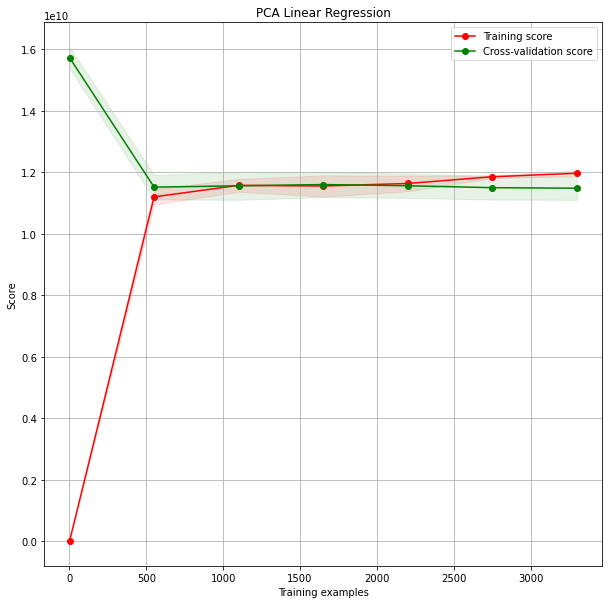

In [28]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression')
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

In [29]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

In [30]:
pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

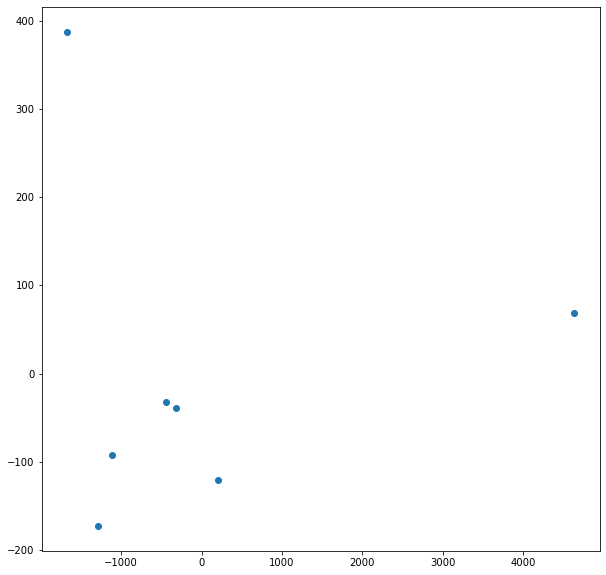

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()

## Parte Solo Ridge Regression

In [32]:
alpha_vals = numpy.linspace(0.01, 2.0, 20)
train_score, val_score = validation_curve(Ridge(alpha=0.01, normalize=True), X, y, 'alpha', alpha_vals, cv=5, scoring=RMS)

In [33]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

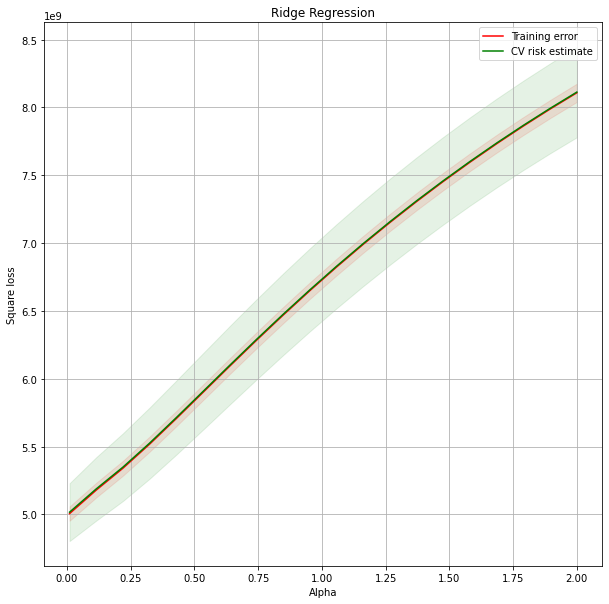

In [34]:
plt.figure(figsize=(10, 10))
plt.title('Ridge Regression')
plt.grid()

plt.fill_between(alpha_vals, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color="r")
plt.fill_between(alpha_vals, val_score_mean - val_score_std, val_score_mean + val_score_std, alpha=0.1, color="g")

plt.plot(alpha_vals, train_score_mean, color="r", label="Training error")
plt.plot(alpha_vals, val_score_mean, color="g", label="CV risk estimate")

plt.xlabel('Alpha')
plt.ylabel('Square loss')
plt.legend()
plt.show()

In [35]:
l_train_size, l_train_score, l_val_score = learning_curve(LinearRegression(normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)
r_train_size, r_train_score, r_val_score = learning_curve(Ridge(alpha=0.01, normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [36]:
l_val_score_mean = -numpy.mean(l_val_score, axis=1)
l_val_score_std = numpy.std(l_val_score, axis=1)
r_val_score_mean = -numpy.mean(r_val_score, axis=1)
r_val_score_std = numpy.std(r_val_score, axis=1)

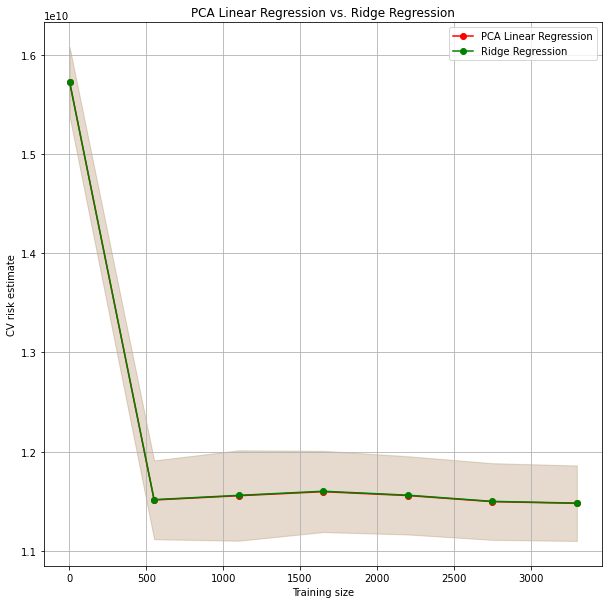

In [37]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression vs. Ridge Regression')
plt.grid()

plt.fill_between(sizes, l_val_score_mean - l_val_score_std, l_val_score_mean + l_val_score_std, alpha=0.1, color="r")
plt.fill_between(sizes, r_val_score_mean - r_val_score_std, r_val_score_mean + r_val_score_std, alpha=0.1, color="g")

plt.plot(sizes, l_val_score_mean, 'o-', color="r", label="PCA Linear Regression")
plt.plot(sizes, r_val_score_mean, 'o-', color="g", label="Ridge Regression")

plt.xlabel('Training size')
plt.ylabel('CV risk estimate')
plt.legend()
plt.show()